# ReAct
= reasoning + action

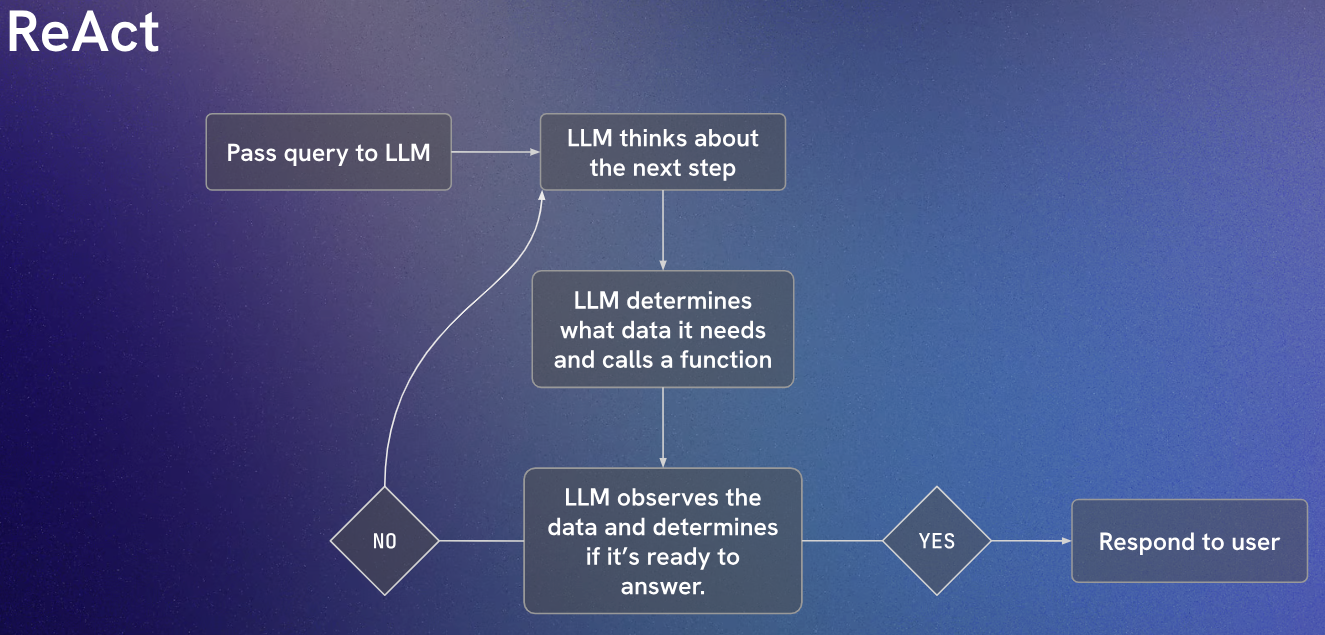
1. People query
2. llm thinks about what tool to use
3. Call tool
4. Judge result
5. If not good, repeat 2-4
6. If good, return result

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import google.generativeai as genai
from dotenv import load_dotenv
import os
import json
import re
from wikipedia_tool import WikipediaTools

# Load environment variables from .env file
load_dotenv()

# Access the API key from the environment variable
api_key = os.getenv("SECRET_KEY")

# Configure the API key for the genai library
genai.configure(api_key=api_key)
model = genai.GenerativeModel(
    "gemini-1.5-flash",
    generation_config=genai.GenerationConfig(temperature=0.1),
)

# 1. create a prompt temple

In [3]:
def generate_system_prompt(query, history, tools, tool_names: str):
    # reference: https://medium.com/google-cloud/building-react-agents-from-scratch-a-hands-on-guide-using-gemini-ffe4621d90ae
    temple = (
        f"\n You are a ReAct (Reasoning and Acting) agent tasked with answering the following query:"
        f"\n Query: {query}"
        f"\n Your goal is to reason about the query and decide on the best course of action to answer it accurately."
        f"\n Previous reasoning steps and observations: {history}"
        f"\n Available tools: {tools}"
        f"\n Instructions:"
        f"\n 1. Analyze the query, previous reasoning steps, and observations."
        f"\n 2. Decide on the next action: use a tool or provide a final answer."
        f"\n 3. Respond in the following JSON format:"
        f"\n If you need to use a tool:"
        f"\n {{"
        f"\n 'thought': 'Your detailed reasoning about what to do next',"
        f"\n 'action': {{"
        f"\n 'name': 'Tool name ({tool_names} or none)',"
        f"\n 'reason': 'Explanation of why you chose this tool',"
        f"\n 'input': 'Specific input for the tool, if different from the original query'"
        f"\n }}"
        f"\n }}"
        f"\n If you have enough information to answer the query:"
        f"\n {{"
        f"\n 'thought': 'Your final reasoning process',"
        f"\n 'answer': 'Your comprehensive answer to the query'"
        f"\n }}"
        f"\n Remember:"
        f"\n - Be thorough in your reasoning."
        f"\n - Use tools when you need more information."
        f"\n - Always base your reasoning on the actual observations from tool use."
        f"\n - If a tool returns no results or fails, acknowledge this and consider using a different tool or approach."
        f"\n - Provide a final answer only when you're confident you have sufficient information."
        f"\n - If you cannot find the necessary information after using available too"
    )
    return temple

# 2. build a loop following the flowchart

## 2.1 get reasoning

In [4]:
def generate_whole_query(query, history, tools: list, tool_names: list) -> str:
    """
    Generate a whole query for the model to follow the ReAct flowchart.
    """
    tool_names_str = ""
    for n in tool_names:
        tool_names_str += f"{n} "
    template = generate_system_prompt(query, history, tools, tool_names_str)
    return [{"role": "user", "parts": template}]

In [5]:
def response_to_json(response_text: str) -> dict:
    """
    Convert the response text to a JSON object.
    """
    try:
        # Find the start and end indices of the JSON object
        start_index = response_text.find("{")
        response_text = response_text[start_index:]

        # Find the end index of the JSON object
        end_index = response_text.rfind("}")
        response_text = response_text[: end_index + 1]

        json_content = json.loads(response_text)

    except Exception as e:
        print(f"Error parsing JSON: {e}")
        return {}
    return json_content

In [6]:
def ask_and_save_history(
    question: str,
    history: list,
    tools: list,
    tool_names: list,
    model: genai.GenerativeModel,
    print_out: bool = False,
) -> str:
    """
    Ask a question to the model and save the question and answer to history.
    """
    whole_query = generate_whole_query(question, history, tools, tool_names)
    response = model.generate_content(whole_query)
    if print_out:
        print(response.text)
    history.append({"role": "model", "parts": response.text})
    return whole_query, response.text

In [20]:
def wiki_query(question, history: list, max_iteration=3, print_out: bool = False):
    tools = WikipediaTools.get_functions_with_descriptions()
    tool_names = WikipediaTools.get_function_names()

    history.append({"role": "user", "parts": question})

    for i in range(max_iteration):
        if print_out:
            print(f"================= Step {i}")
        whole_query, response_text = ask_and_save_history(
            question, history, tools, tool_names, model, print_out
        )

        json_response = response_to_json(response_text)
        if not json_response:
            return None

        if "answer" not in json_response and "action" not in json_response:
            return None

        # answer
        if "answer" in json_response:
            if print_out:
                print(f"found answer:{json_response['answer']}")
            return json_response["answer"]

        # action
        # "action" in json_response:
        else:
            func_name = json_response["action"]["name"]
            arguments = json_response["action"]["input"]
            if print_out:
                print(f"function: {func_name}, arguments: {arguments}")
            if func_name not in tool_names:
                print(f"Function {func_name} not found in tools")
                return None
            func = getattr(WikipediaTools, func_name)
            # haven't found a better way to handle this
            if isinstance(arguments, str):
                result = func(arguments)
            else:
                result = func(**arguments)
            history.append(
                {
                    "role": "function",
                    "name": func_name,
                    "arguments": arguments,
                    "result": result,
                }
            )

In [21]:
history = []
MAX_ITERATION = 3
question_1 = "Can give me a summary of AI in wikipedia?"

answer = wiki_query(question_1, history, max_iteration=MAX_ITERATION)
print(answer)

Artificial intelligence (AI) is broadly defined as intelligence demonstrated by machines, especially computer systems.  It's a computer science field focused on developing methods and software enabling machines to perceive their environment and use learning and intelligence to achieve goals.  High-profile AI applications include search engines, recommendation systems, virtual assistants, autonomous vehicles, and creative tools.  Many AI applications are not explicitly labeled as such, as the technology becomes integrated into everyday use.  AI research encompasses various subfields with specific goals and tools.


In [24]:
history = []
MAX_ITERATION = 3
question_1 = "Is there a page about Maria?"

answer = wiki_query(question_1, history, max_iteration=MAX_ITERATION, print_out=True)
print(answer)

================= Step 0
```json
{
  "thought": "The query asks if there is a Wikipedia page about Maria.  This is too broad.  There are many people named Maria. To answer accurately, I need to use the search_wikipedia_pages tool to see if any pages about a Maria are found. If results are returned, I will need to determine if any are sufficiently notable to warrant a 'yes' answer. If no results are returned, I will answer 'no'.",
  "action": {
    "name": "search_wikipedia_pages",
    "reason": "This tool allows me to search for Wikipedia pages related to 'Maria'.  The results will inform whether there is at least one page about a person named Maria.",
    "input": "Maria"
  }
}
```

function: search_wikipedia_pages, arguments: Maria
================= Step 1
```json
{
  "thought": "The `search_wikipedia_pages` tool returned a list of Wikipedia pages containing \"Maria\" in the title.  This confirms that there are multiple pages about people named Maria.  The query is too broad to answe

In [25]:
question_2 = "Can you show me what are the example?"
answer = wiki_query(question_2, history, max_iteration=MAX_ITERATION, print_out=True)
print(answer)

================= Step 0
```json
{
  "thought": "The user asked for examples, likely referring to examples of Wikipedia pages about people named Maria.  Since I already have a list of Wikipedia pages containing \"Maria\" in the title from a previous search, I can use this information to provide examples. I will select a few representative examples from the list and provide their titles as examples.",
  "answer": "Here are some examples of Wikipedia pages about people named Maria from my previous search:\n\n* Maria Callas\n* Maria Theresa\n* Maria Christina\n* Mai Mizuhashi\n\nThese are just a few examples; many more Wikipedia pages exist about individuals named Maria."
}
```

found answer:Here are some examples of Wikipedia pages about people named Maria from my previous search:

* Maria Callas
* Maria Theresa
* Maria Christina
* Mai Mizuhashi

These are just a few examples; many more Wikipedia pages exist about individuals named Maria.
Here are some examples of Wikipedia pages about p